1. [Manual Vehicle Detection](#Manual Vehicle Detection)
2. [Feature](#Feature)
    1. [Teplate Matching](#Teplate Matching)
    2. [Histograms of Colour](#Histograms of Colour)
    3. [Histogram Comparison](#Histogram Comparison)
    4. [Explore Colour Sapces](#Explore Colour Sapces)
    5. [Spatial Binning of Colour](#Spatial Binning of Colour)
3. [Gradient Features](#Gradient Features)
    1. [HOG Features](#HOG Features)
    2. [scikit-image HOG](#scikit-image HOG)
4. [Combining Features (Combine and Normalize Features)](#Combining Features)
5. [Build A Classifier](#Build A Classifier)
    1. [Labeled Data](#Labeled Data)
    2. [Paremeter Tuning](#Paremeter Tuning)
    3. [Color Classify](#Color Classify)
    4. [HOG Classify](#HOG Classify)
    5. [How many windows?](#How many windows?)
    6. [Sliding Window Implementation](#Sliding Window Implementation)
    7. [Multiple Detections & False Positives](#Multiple Detections & False Positives)

# 1. Manual Vehicle Detection<a name='Manual Vehicle Detection'></a>

<img src='Figures/1. bbox-example-image.jpg' width=500>

Here's our chance to be a human vehicle detector! In this lesson, we will be drawing a lot of bounding boxes on vehicle positions in images. Eventually, we'll have an algorithm that's spewing out bounding box positions and we'll want an easy way to plot them up over our images. So, now is a good time to get familiar with the __cv2.rectangle()__ function ([documentation](http://docs.opencv.org/2.4/modules/core/doc/drawing_functions.html)) that makes it easy to draw boxes of different size, shape and color.

In this exercise, our goal is to write a function that takes as its arguments, an image, and a list of bounding box coordinates for each car. Our function should then draw bounding boxes on a copy of the image and return that as its output as the image below.

<img src='Figures/1. manual-bbox-quiz-output.jpg' width=500>

```Python
# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
```

We'll draw bounding boxes with __cv2.rectangle()__ like this:
```Python
cv2.rectangle(image_to_draw_on, (x1, y1), (x2, y2), color, thick)
```

In this call to __cv2.rectangle()__ our __image\_to\_draw\_on__ should be the copy of our image, then __(x1, y1)__ and __(x2, y2)__ are the $x$ and $y$ coordinates of any two opposing corners of the bounding box we want to draw. __color__ is a 3-tuple, for example, __(0, 0, 255)__ for blue, and __thick__ is an optional integer parameter to define the box thickness.

Have a look at the image above with labeled axes, where some bounding boxes and "guesstimate" where some of the box corners are were drawn. We should pass our bounding box positions to our __draw_boxes()__ function as a list of tuple pairs, like this:
```Python
bboxes = [((x1, y1), (x2, y2)), ((,),(,)), ...]
```

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
image = mpimg.imread('Figures/1. bbox-example-image.jpg')

# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    return draw_img # Change this line to return image copy with boxes
# Add bounding boxes in this format, these are just example coordinates.
bboxes = [((275, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
          ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]

result = draw_boxes(image, bboxes)
plt.imshow(result)

# 2. Feature <a name='Feature'></a>

__QUIZ: Feature Intuition__

Features describe the characteristics of an object, and with images, it really all comes down to intensity and gradients of intensity, and how these features capture the color and shape of an object.

<img src='Figures/2. Feature Intuition.png' width=500>

### 2.1. Teplate Matching <a name='Teplate Matching'></a>

<img src='Figures/3. bbox-example-image.jpg' width=500>

To figure out when template matching works and when it doesn't, let's play around with the OpenCV __cv2.matchTemplate()__ function! In the bounding boxes exercise, we found six cars in the image above. This time, we're going to play the opposite game. Assuming we know these six cars are what we're looking for, we can use them as templates and search the image for matches.

__Let's suppose we want to find the templates shown below in the image shown above:__

<img src='Figures/3. cutout1.jpg' width=150>
<img src='Figures/3. cutout2.jpg' width=150>
<img src='Figures/3. cutout3.jpg' width=150>
<img src='Figures/3. cutout4.jpg' width=150>
<img src='Figures/3. cutout5.jpg' width=150>
<img src='Figures/3. cutout6.jpg' width=150>

Our goal in this exercise is to write a function that takes in an image and a list of templates, and returns a list of the best fit location (bounding box) for each of the templates within the image. OpenCV provides us with the handy function __cv2.matchTemplate()__ ([documentation](http://docs.opencv.org/2.4/modules/imgproc/doc/object_detection.html)) to search the image, and __cv2.minMaxLoc()__ ([documentation](http://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html?highlight=minmaxloc#cv2.minMaxLoc)) to extract the location of the best match.

We can choose between "squared difference" or "correlation" methods in using __cv2.matchTemplate()__, but keep in mind with squared differences we need to locate the global minimum difference to find a match, while for correlation, we're looking for a global maximum.

Follow along with [this tutorial](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_template_matching/py_template_matching.html) provided by OpenCV to try some different template matching techniques. The function we write should work like this:

```Python
def find_matches(img, template_list):
    # Iterate over the list of templates
    # Use cv2.matchTemplate() to search the image for each template
    # NOTE: You can use any of the cv2.matchTemplate() search methods
    # Use cv2.minMaxLoc() to extract the location of the best match in each case
    # Compile a list of bounding box corners as output
    # Return the list of bounding boxes
```

__However__, the point of this exercise is not to discover why template matching works for vehicle detection, but rather, why it doesn't! So, after we have a working implementation of the __find\_matches()__ function, try it on the second image, __temp-matching-example-2.jpg__, which is currently commented out.

In the second image, all of the same six cars are visible (just a few seconds later in the video), but we'll find that none of the templates find the correct match! This is because with template matching we can only find very close matches, and changes in size or orientation of a car make it impossible to match with a template.

So, just to be clear, our goal here is to:

- Write a function that takes in an image and list of templates and returns a list of bounding boxes.
- Find that our function works well to locate the six example templates taken from the first image.
- Try our code on the second image, and find that template matching breaks easily.

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

image = mpimg.imread('Figures/3. bbox-example-image.jpg')
#image = mpimg.imread('temp-matching-example-2.jpg')
templist = ['Figures/3. cutout1.jpg', 'Figures/3. cutout2.jpg', 'Figures/3. cutout3.jpg',
            'Figures/3. cutout4.jpg', 'Figures/3. cutout5.jpg', 'Figures/3. cutout6.jpg']

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image and a list of templates as inputs
# then searches the image and returns the a list of bounding boxes 
# for matched templates
def find_matches(img, template_list):
    # Make a copy of the image to draw on
    # Define an empty list to take bbox coords
    bbox_list = []
    # Iterate through template list
    # Read in templates one by one
    # Use cv2.matchTemplate() to search the image
    #     using whichever of the OpenCV search methods you prefer
    # Use cv2.minMaxLoc() to extract the location of the best match
    # Determine bounding box corners for the match
    # Return the list of bounding boxes
    return bbox_list

bboxes = find_matches(image, templist)
result = draw_boxes(image, bboxes)
plt.imshow(result)

__Answer:__
```Python
# Define a function to search for template matches
# and return a list of bounding boxes
def find_matches(img, template_list):
    # Define an empty list to take bbox coords
    bbox_list = []
    # Define matching method
    # Other options include: cv2.TM_CCORR_NORMED', 'cv2.TM_CCOEFF', 'cv2.TM_CCORR',
    #         'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'
    method = cv2.TM_CCOEFF_NORMED
    # Iterate through template list
    for temp in template_list:
        # Read in templates one by one
        tmp = mpimg.imread(temp)
        # Use cv2.matchTemplate() to search the image
        result = cv2.matchTemplate(img, tmp, method)
        # Use cv2.minMaxLoc() to extract the location of the best match
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        # Determine a bounding box for the match
        w, h = (tmp.shape[1], tmp.shape[0])
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        # Append bbox position to list
        bbox_list.append((top_left, bottom_right))
        # Return the list of bounding boxes
        
    return bbox_list
```

---
So the exercise in finding cars has so far been mostly for the purpose of getting you familiarized with searching for objects in an image and drawing bounding boxes where we find them. But before we move on, one more quiz for intuition on the method of template matching!

__ Quiz: Template Matching__

<img src='Figures/4. 10-q-quiz-slide-v2.png' width=500>

Assume our template is the car image on the left marked "template". If the other cars (A-D) were located somewhere in an image, which ones would we find to be a match using template matching?

1. A
2. B
3. C
4. D

__Answer: B__

Only the image where the car is very close to the same orientation, size, and color will be a match to this template.

### 2.2. Histograms of Colour <a name='Histograms of Colour'></a>

We've looked at using raw pixel intensities as features and now we'll look at histograms of pixel intensity (color histograms) as features.

We'll use the template shown below from the last exercise as an example. 

We can construct histograms of the R, G, and B channels like this:
```Python
import matplotlib.image as mpimg
import numpy as np

# Read in the image
image = mpimg.imread('cutout1.jpg')

# Take histograms in R, G, and B
rhist = np.histogram(image[:,:,0], bins=32, range=(0, 256))
ghist = np.histogram(image[:,:,1], bins=32, range=(0, 256))
bhist = np.histogram(image[:,:,2], bins=32, range=(0, 256))
```

With __np.histogram()__, we don't actually have to specify the number of bins or the range, but here we've arbitrarily chosen __32 bins__ and specified __range=(0, 256)__ in order to get orderly bin sizes. __np.histogram()__ returns a tuple of two arrays. In this case, for example, __rhist[0]__ contains the counts in each of the bins and __rhist[1]__ contains the bin edges (so it is one element longer than __rhist[0]__).

To look at a plot of these results, we can compute the bin centers from the bin edges. Each of the histograms in this case have the same bins, so we'll just use the __rhist__ bin edges:
```Python
# Generating bin centers
bin_edges = rhist[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
```

And then plotting up the results in a bar chart:
```Python
# Plot a figure with all three bar charts
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, rhist[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(132)
plt.bar(bin_centers, ghist[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(133)
plt.bar(bin_centers, bhist[0])
plt.xlim(0, 256)
plt.title('B Histogram')
```

Which gives us this result:
<img src='Figures/4. rgb-histogram-plot.jpg' width=500>

These, collectively, are now our feature vector for this particular cutout image. We can concatenate them in the following way:
```Python
hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
```

__Quiz:__
Having a function that does all these steps might be useful for the project so for this next exercise, our goal is to write a function that takes an image and computes the RGB color histogram of features given a particular number of bins and pixels intensity range, and returns the concatenated RGB feature vector, like this:
```Python
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    # Concatenate the histograms into a single feature vector
    # Return the feature vector
```

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

image = mpimg.imread('Figures/3. cutout1.jpg')

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = None
    ghist = None
    bhist = None
    # Generating bin centers
    bin_centers = None
    # Concatenate the histograms into a single feature vector
    hist_features = None
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features
    
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Function is returning None for at least one variable...')

__Answer:__
```Python
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features
```

### 2.3. Histogram Comparison <a name='Histogram Comparison'></a>

Let's look at the color histogram features for two totally different images. The first image is of a red car and the second a blue car. The red car's color histograms are displayed on the first row and the blue car's are displayed on the second row below. Here we are just looking at 8 bins per RGB channel.

If we had to, we could differentiate the two images based on the differences in histograms alone. As expected the image of the red car has a greater intensity of total bin values in the __R Histogram 1__ (Red Channel) compared to the blue car's __R Histogram 2__. In contrast the blue car has a greater intensity of total bin values in __B Histogram 2__ (Blue Channel) than the red car's __B Histogram 1__ features.

<img src='Figures/4. hist-compare.jpg' width=500>

Differentiating images by the intensity and range of color they contain can be helpful for looking at car vs non-car images.

### 2.4. Explore Colour Sapces <a name='Explore Colour Sapces'></a>

We can study the distribution of color values in an image by plotting each pixel in some color space. Here's a code snippet that we can use to generate 3D plots:
```Python
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
img = cv2.imread("000275.png")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()
```

Use this to first explore some video frames, and see if we can locate clusters of colors that correspond to the sky, trees, specific cars, etc. Here are some sample images to use (these are taken from the [KITTI Vision Benchmark Suite](http://www.cvlibs.net/datasets/kitti/)):

<img src='Figures/5. 000275.png' width=500>
<img src='Figures/5. 001240.png' width=500>
<img src='Figures/5. 000528.png' width=500>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
img = cv2.imread("Figures/5. 000275.png")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

It is hard to distinguish between the class of pixels we are interested in (vehicles, in this case) from the background. So it may be more beneficial to plot pixels from vehicle and non-vehicle images separately. See if we can identify any trends using these samples:

<img src='Figures/5. 25.png' width=100>
<img src='Figures/5. 31.png' width=100>
<img src='Figures/5. 53.png' width=100>
<img src='Figures/5. 8.png' width=100>
<img src='Figures/5. 2.png' width=100>
<img src='Figures/5. 3.png' width=100>

Try experimenting with different color spaces such as LUV or HLS to see if we can find a way to consistently separate vehicle images from non-vehicles. It doesn't have to be perfect, but it will help when combined with other kinds of features fed into a classifier.

### 2.5. Spatial Binning of Colour <a name='Spatial Binning of Colour'></a>

<img src='Figures/6. spatial-binning.jpg' width=500>

We saw earlier in the lesson that template matching is not a particularly robust method for finding vehicles unless we know exactly what our target object looks like. However, raw pixel values are still quite useful to include in our feature vector in searching for cars.

While it could be cumbersome to include three color channels of a full resolution image, we can perform spatial binning on an image and still retain enough information to help in finding vehicles.

As we can see in the example above, even going all the way down to 32 x 32 pixel resolution, the car itself is still clearly identifiable by eye, and this means that the relevant features are still preserved at this resolution.

A convenient function for scaling down the resolution of an image is OpenCV's __cv2.resize()__. We can use it to scale a colour image or a single colour channel like this:

In [ ]:
import cv2
import matplotlib.image as mpimg

image = mpimg.imread('Figures/6. test_img.jpg')
small_img = cv2.resize(image, (32, 32))
print(small_img.shape)
(32, 32, 3)

If we then wanted to convert this to a one dimensional [feature vector](https://en.wikipedia.org/wiki/Feature_vector), we could simply say something like:

In [ ]:
feature_vec = small_img.ravel()
print(feature_vec.shape)

Ok, but 3072 elements is still quite a few features! Could we get away with even lower resolution? 

Now that we've played with colour spaces a bit, it's probably a good time to write a function that allows us to convert any test image into a feature vector that we can feed our classifier. So, our goal in this exercise is to write a function that takes in an image, a color space conversion, and the resolution we would like to convert it to, and returns a feature vector. Something like this:
```Python
# Define a function that takes an image, a color space, 
# and a new image size
# and returns a feature vector
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    # Use cv2.resize().ravel() to create the feature vector
    # Return the feature vector
```

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
# Read in an image
# You can also read cutout2, 3, 4 etc. to see other examples
image = mpimg.imread('Figures/3. cutout1.jpg')

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    # Use cv2.resize().ravel() to create the feature vector
    features = img.ravel() # Remove this line!
    # Return the feature vector
    return features
    
feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

__Answer:__
```Python
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features
```

# 3. Gradient Features <a name='Gradient Features'></a>

### 3.1. HOG Features <a name='HOG Features'></a>

Here is a [presentation](https://www.youtube.com/watch?v=7S5qXET179I) on using Histogram of Oriented Gradient (HOG) features for pedestrian detection by Navneet Dalal, the original developer of HOG for object detection. We can find his original paper on the subject [here](http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf).

### 3.2. Data Exploration

For the exercises throughout the rest of this lesson, we'll use a relatively small labeled dataset to try out feature extraction and training a classifier. Before we get on to extracting HOG features and training a classifier, let's explore the dataset a bit. This dataset is a subset of the data we'll be starting with for the project.

There's no need to download anything at this point, but if want to, we can download this subset of images for [vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles_smallset.zip) and [non-vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles_smallset.zip).

These datasets are comprised of images taken from the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself. In this exercise, we can explore the data to see what we're working with.

We are also welcome and encouraged to explore the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations). Each of the Udacity datasets comes with a __labels.csv__ file that gives bounding box corners for each object labeled.

<img src='Figures/7. car-not-car-examples.jpg' width=500>

__Quiz:__
Here is the code to extract the car/not-car image filenames into two lists. Write a function that takes in these two lists and returns a dictionary with the keys "n_cars", "n_notcars", "image_shape", and "data_type", like this:
```Python
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    # Define a key "n_notcars" and store the number of notcar images
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    # Define a key "data_type" and store the data type of the test image.
    # Return data_dict
    return data_dict
```

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
#from skimage.feature import hog
#from skimage import color, exposure
# images are divided up into vehicles and non-vehicles

cars = []
notcars = []

car_images = glob.glob('Figures/vehicles_smallset/cars1/*.jpeg')
for image in car_images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
non_car_images = glob.glob('Figures/non-vehicles_smallset/notcars1/*.jpeg')
for image in non_car_images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = 0
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = 0
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = (0, 0, 0)
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = None
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

__Answer:__
```Python
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
```

### 3.3. scikit-image HOG <a name='scikit-image HOG'></a>

The [scikit-image](http://scikit-image.org/) package has a built in function to extract Histogram of Oriented Gradient features. The documentation for this function can be found [here](http://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=feature%20hog#skimage.feature.hog) and a brief explanation of the algorithm and tutorial can be found [here](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html).

The scikit-image __hog()__ function takes in a single color channel or grayscaled image as input, as well as various parameters. These parameters include __orientations__, __pixels_per_cell__ and __cells_per_block__.

The number of __orientations__ is specified as an integer, and represents the number of orientation bins that the gradient information will be split up into in the histogram. Typical values are between 6 and 12 bins.

The __pixels_per_cell__ parameter specifies the cell size over which each gradient histogram is computed. This paramater is passed as a 2-tuple so we could have different cell sizes in $x$ and $y$, but cells are commonly chosen to be square.

The __cells_per_block__ parameter is also passed as a 2-tuple, and specifies the local area over which the histogram counts in a given cell will be normalized. Block normalization is not necessarily required, but generally leads to a more robust feature set.

There is another optional power law or "gamma" normalization scheme set by the flag __transform_sqrt__. This type of normalization may help reduce the effects of shadows or other illumination variation, but will cause an error if our image contains negative values (because it's taking the square root of image values).

<img src='Figures/8. hog-visualization.jpg' width=500>

This is where things get a little confusing though. Let's say we are computing HOG features for an image like the one shown above that is $64×64$ pixels. If we set __pixels_per_cell=(8, 8)__ and __cells_per_block=(2, 2)__ and __orientations=9__. How many elements will we have in our HOG feature vector for the entire image?

Let's guess $the number of orientations times the number of cells$, or $9×8×8=576$, but that's not the case if we're using block normalization! In fact, the HOG features for all cells in each block are computed at each block position and the block steps across and down through the image cell by cell.

So, the actual number of features in our final feature vector will be _the total number of block positions multiplied by the number of cells per block, times the number of orientations_, or in the case shown above: $7×7×2×2×9=1764$.

For the example above, you would call the __hog()__ function on a single color channel __img__ like this:
```Python
from skimage.feature import hog
pix_per_cell = 8
cell_per_block = 2
orient = 9

features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
```

The __visualise=True__ flag tells the function to output a visualization of the HOG feature computation as well, which we're calling __hog_image__ in this case. If we take a look at a single color channel for a random car image, and its corresponding HOG visulization, they look like this:

<img src='Figures/8. car-and-hog.jpg' width=500>

The HOG visualization is not actually the feature vector, but rather, a representation that shows the dominant gradient direction within each cell with brightness corresponding to the strength of gradients in that cell, much like the "star" representation in the last video.

If we look at the __features__ output, we'll find it's an array of shape $7×7×2×2×9$. This corresponds to the fact that a grid of $7×7$ blocks were sampled, with $2×2$ cells in each block and $9$ orientations per cell. We can unroll this array into a feature vector using __features.ravel()__, which yields, in this case, a one dimensional array of length __1764__.

__Quiz:__
Alternatively, we can set the __feature_vector=True__ flag when calling the __hog()__ function to automatically unroll the features. In the project, it could be useful to have a function defined that we could pass an image to with specifications for __orientations__, __pixels_per_cell__, and __cells_per_block__, as well as flags set for whether or not we want the feature vector unrolled and/or a visualization image, so let's write it!

```Python
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        return features
```

__Note__: we could also include a keyword to set the __tranform_sqrt__ flag but for this exercise we can just leave this at the default value of __transform_sqrt=False__.

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
%matplotlib inline

cars = []
notcars = []

car_images = glob.glob('Figures/vehicles_smallset/cars1/*.jpeg')
for image in car_images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
non_car_images = glob.glob('Figures/non-vehicles_smallset/notcars1/*.jpeg')
for image in non_car_images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features = [] # Remove this line
        hog_image = img # Remove this line
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = [] # Remove this line
        return features

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

__Answer:__
```Python
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
```

# 4. Combining Features (Combine and Normalize Features) <a name='Combining Features'></a>

<img src='Figures/9. scaled-features-vis.jpg' width=500>

Now that we've got several feature extraction methods in our toolkit, we're almost ready to train a classifier, but first, as in any machine learning application, we need to normalize our data. Python's __sklearn__ package provides us with the __StandardScaler()__ method to accomplish this task. To read more about how we can choose different normalizations with the __StandardScaler()__ method, check out the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

To apply __StandardScaler()__ we need to first have our data in the right format, as a numpy array where each row is a single feature vector. We will often create a list of feature vectors, and then convert them like this:
```Python
import numpy as np
feature_list = [feature_vec1, feature_vec2, ...]
# Create an array stack, NOTE: StandardScaler() expects np.float64
X = np.vstack(feature_list).astype(np.float64)
```

You can then fit a scaler to $X$, and scale it like this:
```Python
from sklearn.preprocessing import StandardScaler
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
```

Now, __scaled_X__ contains the normalized feature vectors. In this next exercise, we've provided the feature scaling step, but we need to provide the feature vectors. We've also provided versions of the __bin_spatial()__ and __color_hist()__ functions we wrote in previous exercises.

Our goal in this exercise is to write a function that takes in a list of image filenames, reads them one by one, then applies a color conversion (if necessary) and uses __bin_spatial()__ and __color_hist()__ to generate feature vectors. The function should then concatenate those two feature vectors and append the result to a list. After cycling through all the images, the function should return the list of feature vectors. Something like this:
```Python
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
        # Read in each one by one
        # apply color conversion if other than 'RGB'
        # Apply bin_spatial() to get spatial color features
        # Apply color_hist() to get color histogram features
        # Append the new feature vector to the features list
    # Return list of feature vectors
    return features
```

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

###### TODO ###########
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
        # Read in each one by one
        # apply color conversion if other than 'RGB'
        # Apply bin_spatial() to get spatial color features
        # Apply color_hist() to get color histogram features
        # Append the new feature vector to the features list
    # Return list of feature vectors
    return features

cars = []
notcars = []

car_images = glob.glob('Figures/vehicles_smallset/cars1/*.jpeg')
for image in car_images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
non_car_images = glob.glob('Figures/non-vehicles_smallset/notcars1/*.jpeg')
for image in non_car_images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

__Answer:__
```Python
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features
```

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import glob

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

###### TODO ###########
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

cars = []
notcars = []

car_images = glob.glob('Figures/vehicles_smallset/cars1/*.jpeg')
for image in car_images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
non_car_images = glob.glob('Figures/non-vehicles_smallset/notcars1/*.jpeg')
for image in non_car_images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

# 5. Build A Classifier <a name='Build A Classifier'></a>

### 5.1. Labeled Data <a name='Labeled Data'></a>

<img src='Figures/10. Data Preparation.png' width=600>

### 5.2. Paremeter Tuning <a name='Paremeter Tuning'></a>

__SVM Hyperparameters:__ optimize the Gamma and C parameters.

Successfully tuning our algorithm involves searching for a kernel, a gamma value and a C value that minimize prediction error. To tune our SVM vehicle detection model, we can use one of scikit-learn's parameter tuning algorithms.

When tuning SVM, remember that we can only tune the C parameter with a linear kernel. For a non-linear kernel, we can tune C and gamma.

__Parameter Tuning in Scikit-learn:__

Scikit-learn includes two algorithms for carrying out an automatic parameter search:
- [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)
- [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)

_GridSearchCV_ exhaustively works through multiple parameter combinations, cross-validating as it goes. The beauty is that it can work through many combinations in only a couple extra lines of code.

For example, if we input the values C:[0.1, 1, 10] and gamma:[0.1, 1, 10], gridSearchCV will train and cross-validate every possible combination of (C, gamma): (0.1, 0.1), (0.1, 1), (0.1, 10), (1, .1), (1, 1), etc.

_RandomizedSearchCV_ works similarly to GridSearchCV except RandomizedSearchCV takes a random sample of parameter combinations. RandomizedSearchCV is faster than GridSearchCV since RandomizedSearchCV uses a subset of the parameter combinations.

__Cross-validation with GridSearchCV:__

GridSearchCV uses 3-fold cross validation to determine the best performing parameter set. GridSearchCV will take in a training set and divide the training set into three equal partitions. The algorithm will train on two partitions and then validate using the third partition. Then GridSearchCV chooses a different partition for validation and trains with the other two partitions. Finally, GridSearchCV uses the last remaining partition for cross-validation and trains with the other two partitions.

By default, GridSearchCV uses accuracy as an error metric by averaging the accuracy for each partition. So for every possible parameter combination, GridSearchCV calculates an accuracy score. Then GridSearchCV will choose the parameter combination that performed the best.

__Scikit-learn Cross Validation Example:__

Here's an example from the sklearn [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) for implementing GridSearchCV:

```Python
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)
clf.fit(iris.data, iris.target)
```

Let's break this down line by line.

```Python
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]} 
```

A dictionary of the parameters, and the possible values they may take. In this case, they're playing around with the kernel (possible choices are 'linear' and 'rbf'), and C (possible choices are 1 and 10).

Then a 'grid' of all the following combinations of values for (kernel, C) are automatically generated:

||||
|-|-|
|('rbf', 1)|('rbf', 10)|
|('linear', 1)|('linear', 10)|

Each is used to train an SVM, and the performance is then assessed using cross-validation.

```Python
svr = svm.SVC() 
```
This looks kind of like creating a classifier, just like we've been doing since the first lesson. But note that the "clf" isn't made until the next line--this is just saying what kind of algorithm to use. Another way to think about this is that the "classifier" isn't just the algorithm in this case, it's algorithm plus parameter values. Note that there's no monkeying around with the kernel or C; all that is handled in the next line.

```Python
clf = grid_search.GridSearchCV(svr, parameters) 
```
This is where the first bit of magic happens; the classifier is being created. We pass the algorithm (svr) and the dictionary of parameters to try (parameters) and it generates a grid of parameter combinations to try.

```Python
clf.fit(iris.data, iris.target) 
```
And the second bit of magic. The fit function now tries all the parameter combinations, and returns a fitted classifier that's automatically tuned to the optimal parameter combination. We can now access the parameter values via **clf.best\_params\_**.

### 5.3. Color Classify <a name='Color Classify'></a>

<img src='Figures/11. car-color-and-hist.jpg' width=500>

Now we'll try training a classifier on our dataset. First, we'll see how well it does just using spatially binned color and color histograms.

To do this, we'll use the functions we defined in previous exercises, namely, __bin_spatial()__, __color_hist()__, and __extract_features()__. We'll then read in our car and non-car images, extract the color features for each, and scale the feature vectors to zero mean and unit variance.

All that remains is to define a labels vector, shuffle and split the data into training and testing sets, and finally, define a classifier and train it!

Our labels vector __y__ in this case will just be a binary vector indicating whether each feature vector in our dataset corresponds to a car or non-car (1's for cars, 0's for non-cars). Given lists of car and non-car features (the output of __extract_features()__) we can define a labels vector like this:
```Python
import numpy as np
# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))
```

Next, we'll stack and scale our feature vectors like before:
```Python
from sklearn.preprocessing import StandardScaler
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
```

And now we're ready to shuffle and split the data into training and testing sets. To do this we'll use the Scikit-Learn __train_test_split()__ function, but it's worth noting that recently, this function moved from the __sklearn.cross_validation__ package (in __sklearn__ version <=0.17) to the __sklearn.model_selection__ package (in __sklearn__ version >=0.18).

In the quiz editor we're still running __sklearn v0.17__, so we'll import it like this:

```Python
from sklearn.cross_validation import train_test_split
# But, if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
```

__train_test_split()__ performs both the shuffle and split of the data and we'll call it like this (here choosing to initialize the shuffle with a different random state each time):

```Python
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
```

__Warning:__ when dealing with image data that was extracted from video, we may be dealing with sequences of images where our target object (vehicles in this case) appear almost identical in a whole series of images. In such a case, even a randomized train-test split will be subject to overfitting because images in the training set may be nearly identical to images in the test set. For the subset of images used in the next several quizzes, this is not a problem, but to optimize our classifier for the project, we may need to worry about time-series of images!

---
Now, we're ready to define and train a classifier! Here we'll try a Linear Support Vector Machine. To define and train the classifier it takes just a few lines of code:

```Python
from sklearn.svm import LinearSVC
# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Train the SVC
svc.fit(X_train, y_train)
```

Then we can check the accuracy of our classifier on the test dataset like this:
```Python
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
```

Or we can make predictions on a subset of the test data and compare directly with ground truth:
```Python
print('My SVC predicts: ', svc.predict(X_test[0:10].reshape(1, -1)))
print('For labels: ', y_test[0:10])
```

Play with the parameter values __spatial__ and __histbin__ in the exercise below to see how the classifier accuracy and training time vary with the feature vector input.

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

# Divide up into cars and notcars
cars = []
notcars = []

car_images = glob.glob('Figures/vehicles_smallset/cars1/*.jpeg')
for image in car_images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
non_car_images = glob.glob('Figures/non-vehicles_smallset/notcars1/*.jpeg')
for image in non_car_images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 32
histbin = 32

car_features = extract_features(cars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

### 5.4. HOG Classify <a name='HOG Classify'></a>

classification by color features alone is pretty effective! Now let's try classifying with HOG features and see how well we can do.

<img src='Figures/12. car-and-hog.jpg' width=500>

---
__NOTE:__ if we copy the code from the exercise below onto our local machine, but are running sklearn version >= 0.18 we will need to change from calling:

```Python
from sklearn.cross_validation import train_test_split
```

```Python
from sklearn.model_selection import train_test_split
```

---
In the exercise below, we're given all the code to extract HOG features and train a linear SVM. There is no right or wrong answer, but our mission, should we choose to accept it, is to play with the parameters __colorspace__, __orient__, __pix_per_cell__, __cell_per_block__, and __hog_channel__ to get a feel for what combination of parameters give the best results.

__Note:__ __hog_channel__ can take values of 0, 1, 2, or "ALL", meaning that we extract HOG features from the first, second, third, or all color channels respectively.

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


# Divide up into cars and notcars
cars = []
notcars = []

car_images = glob.glob('Figures/vehicles_smallset/cars1/*.jpeg')
for image in car_images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
non_car_images = glob.glob('Figures/non-vehicles_smallset/notcars1/*.jpeg')
for image in non_car_images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

/Users/seongmukgang/anaconda/envs/ComputerVision/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/seongmukgang/anaconda/envs/ComputerVision/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


2.4 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
0.05 Seconds to train SVC...
Test Accuracy of SVC =  0.9688
My SVC predicts:  [ 0.  1.  0.  0.  0.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  0.  0.  1.  0.  0.  0.]
0.00151 Seconds to predict 10 labels with SVC


### 5.5. How many windows? <a name='How many windows?'></a>

<img src='Figures/13. car-identified.jpg' width=500>

To implement a sliding window search, we need to decide what size window we want to search, where in the image we want to start and stop our search, and how much we want windows to overlap. So, let's try an example to see how many windows we would be searching given a particular image size, window size, and overlap.

Suppose we have an image that is $256 x 256$ pixels and we want to search windows of a size $128 x 128$ pixels each with an overlap of 50% between adjacent windows in both the vertical and horizontal dimensions. Our sliding window search would then look like this:
<img src='Figures/13. sliding-window.jpg' width=500>

So, we searched 9 windows total in this case. 

__Quiz:__
Suppose we have an image that is $1280 x 960$ pixels and we want to search the entire image using $64 x 64$ pixel windows with 50% overlap between windows in both the vertical and horizontal directions. How many windows would you be searching total?

__Answer:__ 1131

### 5.6. Sliding Window Implementation <a name='Sliding Window Implementation'></a>

<img src='Figures/14. sliding-window.jpg' width=500>

In the last exercise, we saw how the number of windows scales with image size, window size, and overlap. In the project it will be useful to have a function to perform a sliding window search on an image, so let's write one! This will just be the first iteration, where we don't actually need to do anything besides plot a rectangle at each window position.

So, our goal here is to write a function that takes in an image, start and stop positions in both $x$ and $y$ (imagine a bounding box for the entire search region), window size ($x$ and $y$ dimensions), and overlap fraction (also for both $x$ and $y$). Our function should return a list of bounding boxes for the search windows, which will then be passed to draw draw_boxes() function.

__Quiz:__

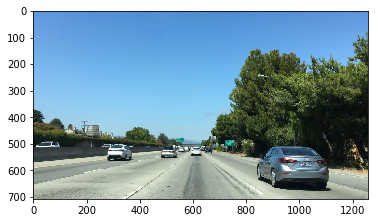

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

image = mpimg.imread('Figures/3. bbox-example-image.jpg')

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    # Compute the span of the region to be searched    
    # Compute the number of pixels per step in x/y
    # Compute the number of windows in x/y
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
        # Calculate each window position
        # Append window position to list
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

__Answer:__
```Python
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list
```

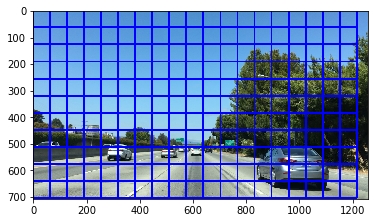

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

image = mpimg.imread('Figures/3. bbox-example-image.jpg')

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

### 5.6. Search and Classify

<img src='Figures/15. bbox-example-image.jpg' width=500>

Now we're able to run a sliding window search on an image and we've trained a classifier... time to combine both steps and search for cars!

We already have all the tools we need to do this from the previous exercises. Just train our classifier, then run our sliding window search, extract features, and predict whether each window contains a car or not. We'll probably find some false positives, but soon we'll deal with removing them.

In the __lesson_functions.py__ tab on the quiz editor, we'll find all the functions we've defined so far in the lesson, including __get_hog_features()__, __bin_spatial()__, __color_hist()__, __extract_features()__, __slide_window()__, and __draw_boxes()__. These are now all imported for use in the quiz with this command:
```Python
from lesson_functions import *
```

Two new functions are defined: __single_img_features()__ and __search_windows()__. We can use these to search over all the windows defined by our __slide_windows()__, extract features at each window position, and predict with our classifier on each set of features.

We have limited the sample size to 500 each of car and not-car training images for the classifier to avoid quiz evaluator timeout, but if we search a very large number of windows or create huge feature vectors, we still may run into timeout issues. If we want to explore more, download the data and try the code on a local machine.

The subset of data can be downloaded used in this lesson for [vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles_smallset.zip) and [non-vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles_smallset.zip), or if prefer, we can directly grab the larger project dataset for [vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles_smallset.zip).

In this exercise, experiment with different color and gradient feature sets, different search window sizes and overlap to get an idea of how our classifier performs with different training features. Getting false positives in the skies and treetops? Try restricting our search area on the image with y_start_stop in the slide_window() function. What combination of features works best?

__lesson_functions.py__

In [4]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

__search_classify.py__

/Users/seongmukgang/anaconda/envs/ComputerVision/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


scaled_X shape:  (796, 2580) y shape:  (796,)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
Input shape:  (636, 2580)
0.09 Seconds to train SVC...
Test Accuracy of SVC =  0.975


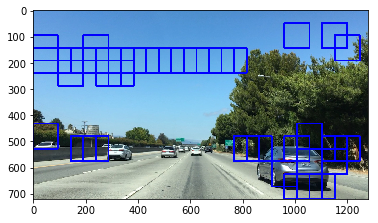

In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


# Read in cars and notcars
# Divide up into cars and notcars
cars = []
notcars = []

car_images = glob.glob('Figures/vehicles_smallset/cars1/*.jpeg')
for image in car_images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
non_car_images = glob.glob('Figures/non-vehicles_smallset/notcars1/*.jpeg')
for image in non_car_images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('scaled_X shape: ', np.shape(scaled_X), 'y shape: ', np.shape(y))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
print('Input shape: ', np.shape(X_train))
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('Figures/1. bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

__Answer:__
```Python
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
```

/Users/seongmukgang/anaconda/envs/ComputerVision/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
1.1 Seconds to train SVC...
Test Accuracy of SVC =  0.985


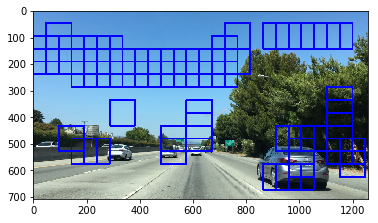

In [6]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
# Read in cars and notcars
# Divide up into cars and notcars
car_images = glob.glob('Figures/vehicles_smallset/cars1/*.jpeg')
for image in car_images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
non_car_images = glob.glob('Figures/non-vehicles_smallset/notcars1/*.jpeg')
for image in non_car_images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('Figures/3. bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

### 5.7. Hog Sub-sampling Window Search

Now lets explore a more efficient method for doing the sliding window approach, one that allows us to only have to extract the Hog features once. The code below defines a single function __find_cars__ that's able to both extract features and make predictions.

The __find_cars__ only has to extract hog features once and then can be sub-sampled to get all of its overlaying windows. Each window is defined by a scaling factor where a scale of 1 would result in a window that's 8 x 8 cells then the overlap of each window is in terms of the cell distance. This means that a __cells_per_step = 2__ would result in a search window overlap of 75%. Its possible to run this same function multiple times for different scale values to generate multiple-scaled search windows.

<img src='Figures/16. hog-sub.jpg' width=500>

__Quiz:__

__lesson_functions.py__

In [7]:
import numpy as np
import cv2
from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

    
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



__hog_subsample.py__

In [15]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
#from lesson_functions import *

dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

img = mpimg.imread('Figures/test_images/test1.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5
    
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

/Users/seongmukgang/anaconda/envs/ComputerVision/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


ValueError: operands could not be broadcast together with shapes (1,8460) (2580,) (1,8460) 

### 5.8. Multiple Detections & False Positives <a name='Multiple Detections & False Positives'></a>

Here are six consecutive frames from the project video and showing all the bounding boxes for where our classifier reported positive detections. We can see that overlapping detections exist for each of the two vehicles, and in two of the frames, we find a false positive detection on the guardrail to the left. In this exercise, we'll build a heat-map from these detections in order to combine overlapping detections and remove false positives.

<img src='Figures/17. Multiple Detections.png' widht=500>

To make a heat-map, we're simply going to add "heat" (+=1) for all pixels within windows where a positive detection is reported by our classifier. The individual heat-maps for the above images look like this:

<img src='Figures/18. Heat Map.png' width=500>

In the exercise below, we are provided with a list of bounding boxes for the detections in the images shown above. Rather than consider heat-maps for each individual image, we'll write a function that adds "heat" to a map for a list of bounding boxes.

```Python
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
```

If our classifier is working well, then the "hot" parts of the map are where the cars are, and by imposing a threshold, we can reject areas affected by false positives. So let's write a function to threshold the map as well.

```Python
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
```

In practice, we will want to integrate a heat map over several frames of video, such that areas of multiple detections get "hot", while transient false positives stay "cool". We can then simply threshold our heatmap to remove false positives.

Once we have a thresholded heat-map, there are many ways we could go about trying to figure out how many cars we have in each frame and which pixels belong to which cars, but one of the most straightforward solutions is to use the __label()__ function from __scipy.ndimage.measurements__. We'll use it like this:

```Python
from scipy.ndimage.measurements import label
labels = label(heatmap)
```

Now __labels__ is a 2-tuple, where the first item is an array the size of the heatmap input image and the second element is the number of labels (cars) found.

In the above series of images the same false positive window appeared twice, so if we set a threshold of 2 (meaning set all values <= 2 to 0) and then run the labels() function. We get a result that 2 cars were identified (the two islands in the heat-map) and the labeled image where pixels are set to 0 for background, 1 for car number 1, and 2 for car number 2.

```Python
heatmap = threshold(heatmap, 2)
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
```

2 cars found
<img src='Figures/18. Heat Map Cars.png' width=500>

Next, we can take our labels image and put bounding boxes around the labeled regions. We could do this in the following manner:
```Python
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Read in the last image above
image = mpimg.imread('img105.jpg')
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(draw_img)
```

And the output looks like this:

<img src='Figures/18. Output.png' width=500>